In [76]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics
import logging
import os
import sys
from cgi import test
from glob import glob
from pydoc import describe
import numpy as np
import pandas as pd
from joblib import dump, load
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    LinearRegression,
    SGDRegressor,
)
from sklearn.model_selection import train_test_split
from sklearn.multioutput import RegressorChain
# from sklearnex import patch_sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, MaxPooling1D
from tensorflow.keras.layers import InputLayer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Model


In [77]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [78]:
# Đọc dữ liệu từ file CSV
df_pre = pd.read_csv('Risk_2 - smooth.csv', sep=",", dtype=str)
df_pre = df_pre[['PM2.5_s', 'wd_s', 'ws_s', 'Rainfall_s', 'lowleaf_s', 'temp_s', 'uvb_s']]
df_pre.head()

,PM2.5_s,wd_s,ws_s,Rainfall_s,lowleaf_s,temp_s,uvb_s
0,24.33,349.33,1.37,0.00,1.92,296.92,0.00
1,27.33,341.67,1.37,0.00,1.92,296.40,0.00
2,31.33,342.00,1.40,0.00,1.92,295.95,0.00
3,33.00,346.33,1.33,0.00,1.92,295.94,4580.61
4,36.67,245.00,1.20,0.00,1.92,296.41,29870.49


In [79]:
values = df_pre.values
# ensure all data is float
values = values.astype('float32')
temp = pd.DataFrame(values)
temp.head()

,0,1,2,3,4,5,6
0,24.330000,349.329987,1.37,0.0,1.92,296.920013,0.000000
1,27.330000,341.670013,1.37,0.0,1.92,296.399994,0.000000
2,31.330000,342.000000,1.40,0.0,1.92,295.950012,0.000000
3,33.000000,346.329987,1.33,0.0,1.92,295.940002,4580.609863
4,36.669998,245.000000,1.20,0.0,1.92,296.410004,29870.490234


In [80]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [81]:
#Single timestep no scale
# frame as supervised learning
n_hours = 6 # check timestep change  timestep to evaluate performance


n_features = 7  # fixed 7 values in data  (PM2.5_s	wd_s	ws_s	Rainfall_s	lowleaf_s	temp_s	uvb_s)
reframed = series_to_supervised(scaled, n_hours, 1)  # apply scaled not values
reframed.head()


,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var1(t-5),var2(t-5),var3(t-5),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
6,0.152534,0.971198,0.183261,0.0,0.466667,0.222088,0.000000,0.172148,0.949861,0.183261,...,0.466667,0.274557,0.185934,0.174371,0.107688,0.115440,0.0,0.466667,0.367296,0.368548
7,0.172148,0.949861,0.183261,0.0,0.466667,0.190359,0.000000,0.198300,0.950780,0.187590,...,0.466667,0.367296,0.368548,0.156914,0.085404,0.096681,0.0,0.466667,0.458206,0.557556
8,0.198300,0.950780,0.187590,0.0,0.466667,0.162905,0.000000,0.209219,0.962841,0.177489,...,0.466667,0.458206,0.557556,0.165610,0.332396,0.076479,0.0,0.466667,0.529591,0.705831
9,0.209219,0.962841,0.177489,0.0,0.466667,0.162294,0.010598,0.233213,0.680585,0.158730,...,0.466667,0.529591,0.705831,0.189604,0.578440,0.057720,0.0,0.466667,0.593655,0.781249
10,0.233213,0.680585,0.158730,0.0,0.466667,0.190971,0.069108,0.198300,0.399248,0.139971,...,0.466667,0.593655,0.781249,0.226675,0.733510,0.033189,0.0,0.466667,0.640635,0.747778


In [82]:
# Chia dữ liệu thành train và test
n_train_hours = 32469  - n_hours -1# hết năm 2021
values = reframed.values
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [83]:

# Chia thành input và outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

print("train_X shape:", train_X.shape)
print("train_y shape:", train_y.shape)

train_X shape: (32462, 42)
train_y shape: (32462,)


In [84]:
# Reshape input thành dạng 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


In [49]:
# Định nghĩa mô hình CNN + LSTM
inputs = Input(shape=(n_hours, n_features))
x = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(inputs)
x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)
model_cnn_lstm = Model(inputs, outputs)
model_cnn_lstm.compile(optimizer='adam', loss='mse')
model_cnn_lstm.summary()

# Huấn luyện
model_cnn_lstm.fit(train_X, train_y, epochs=67, batch_size=32, validation_data=(test_X, test_y), verbose=1)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 6, 256)              │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 211,073 (824.50 KB)

 Trainable params: 211,073 (824.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/67
 304/1015 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0045

KeyboardInterrupt: 

In [50]:
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
import tensorflow.keras.ops as K  # Sử dụng keras.ops thay vì tf

# Định nghĩa CBAM
def cbam_block(input_tensor, reduction_ratio=16):
    # Channel Attention
    channel_avg = GlobalAveragePooling1D()(input_tensor)
    channel_max = GlobalMaxPooling1D()(input_tensor)
    channel_shared = Dense(units=int(input_tensor.shape[-1] // reduction_ratio), activation='relu')
    channel_avg = channel_shared(channel_avg)
    channel_max = channel_shared(channel_max)
    channel_avg = Dense(units=input_tensor.shape[-1], activation='sigmoid')(channel_avg)
    channel_max = Dense(units=input_tensor.shape[-1], activation='sigmoid')(channel_max)
    channel_attention = Multiply()([input_tensor, K.add(channel_avg, channel_max)])  # Sử dụng K.add thay vì phép cộng trực tiếp

    # Spatial Attention
    spatial_avg = K.mean(channel_attention, axis=-1, keepdims=True)  # Sử dụng K.mean thay vì tf.reduce_mean
    spatial_max = K.max(channel_attention, axis=-1, keepdims=True)   # Sử dụng K.max thay vì tf.reduce_max
    spatial_concat = K.concatenate([spatial_avg, spatial_max], axis=-1)  # Sử dụng K.concatenate thay vì tf.concat
    spatial_attention = Conv1D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(spatial_concat)
    return Multiply()([channel_attention, spatial_attention])

# Định nghĩa mô hình CNN + BiLSTM + CBAM
inputs = Input(shape=(n_hours, n_features))
x = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(inputs)
x = cbam_block(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)
model_cnn_bilstm_cbam = Model(inputs, outputs)
model_cnn_bilstm_cbam.compile(optimizer='adam', loss='mse')
model_cnn_bilstm_cbam.summary()


# Huấn luyện
model_cnn_bilstm_cbam.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), verbose=1)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 6, 7)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 6, 256)         │          5,632 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 256)            │              0 │ conv1d_20[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_8    │ (None, 256)            │              0 │ conv1d_20[0][0]        │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 16)             │          4,112 │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_45 (Dense)          │ (None, 256)            │          4,352 │ dense_44[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_46 (Dense)          │ (None, 256)            │          4,352 │ dense_44[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 256)            │              0 │ dense_45[0][0],        │
│                           │                        │                │ dense_46[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_14 (Multiply)    │ (None, 6, 256)         │              0 │ conv1d_20[0][0],       │
│                           │                        │                │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean_6 (Mean)             │ (None, 6, 1)           │              0 │ multiply_14[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_6 (Max)               │ (None, 6, 1)           │              0 │ multiply_14[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 6, 2)           │              0 │ mean_6[0][0],          │
│ (Concatenate)             │                        │                │ max_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 6, 1)           │             15 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_15 (Multiply)    │ (None, 6, 256)         │              0 │ multiply_14[0][0],     │
│                           │                        │                │ conv1d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ (None, 6, 256)         │        394,240 │ multiply_15[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├──────────────────────

 Total params: 429,216 (1.64 MB)

 Trainable params: 429,216 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0030 - val_loss: 6.8619e-04
Epoch 2/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 8.1661e-04 - val_loss: 5.1275e-04
Epoch 3/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 7.3276e-04 - val_loss: 0.0011
Epoch 4/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 7.0061e-04 - val_loss: 5.3559e-04
Epoch 5/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 6.6769e-04 - val_loss: 5.0949e-04
Epoch 6/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 7.0566e-04 - val_loss: 6.5931e-04
Epoch 7/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 6.4521e-04 - val_loss: 5.9659e-04
Epoch 8/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 6.6082e-04 - val_loss: 5.3626e-04
Epoch 9/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 6.7551e-04 - val_loss: 4.9878e-04
Epoch 10/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 6.5813e-04 - val_loss: 7.3464e-04


In [69]:
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer  # Thêm dòng này để import Layer
import tensorflow.keras.backend as K  # Sử dụng Keras backend để tính toán

# Định nghĩa Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        alpha = K.softmax(e, axis=1)
        context = inputs * alpha
        return K.sum(context, axis=1)

# Định nghĩa mô hình CNN + BiLSTM + Attention
inputs = Input(shape=(n_hours, n_features))
x = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(inputs)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = AttentionLayer()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)
model_cnn_bilstm_attention = Model(inputs, outputs)
model_cnn_bilstm_attention.compile(optimizer='adam', loss='mse')
model_cnn_bilstm_attention.summary()

# Huấn luyện
model_cnn_bilstm_attention.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), verbose=1)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 6, 256)              │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 6, 256)              │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 256)                 │             262 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 416,647 (1.59 MB)

 Trainable params: 416,647 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.0031 - val_loss: 7.3458e-04
Epoch 2/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 8.0569e-04 - val_loss: 5.2864e-04
Epoch 3/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 7.4725e-04 - val_loss: 5.0354e-04
Epoch 4/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 7.4252e-04 - val_loss: 5.0712e-04
Epoch 5/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 6.9939e-04 - val_loss: 6.0370e-04
Epoch 6/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 6.5695e-04 - val_loss: 5.3733e-04
Epoch 7/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 6.6547e-04 - val_loss: 5.0512e-04
Epoch 8/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 6.5234e-04 - val_loss: 6.6048e-04
Epoch 9/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 6.4049e-04 - val_loss: 5.3225e-04
Epoch 10/10
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 6.2057e-04 - val_loss: 4.8467e-04


In [ ]:
'''
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Định nghĩa Transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    ffn = Dense(ff_dim, activation='relu')(x)
    ffn = Dense(inputs.shape[-1])(ffn)
    x = Dropout(dropout)(ffn)
    return LayerNormalization(epsilon=1e-6)(x + ffn)

# Định nghĩa mô hình Transformer
inputs = Input(shape=(n_hours, n_features))
x = transformer_block(inputs, head_size=256, num_heads=4, ff_dim=128, dropout=0.2)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)
model_transformer = Model(inputs, outputs)
model_transformer.compile(optimizer='adam', loss='mse')
model_transformer.summary()

# Huấn luyện
model_transformer.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), verbose=1)
'''

In [22]:
# Huấn luyện mô hình
history = model.fit(train_X, train_y, epochs=67 , batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False,)


NameError: name 'model' is not defined

In [86]:
# Dự đoán
# yhat = model_cnn_lstm.predict(test_X)
#yhat = model_cnn_bilstm_cbam.predict(test_X)
#yhat = model_cnn_bilstm_attention.predict(test_X)
yhat = model_transformer.predict(test_X)
#yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours * n_features))

349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [87]:
# Đảo ngược chuẩn hóa cho dự đoán
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features - 1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]


In [89]:
# Đảo ngược chuẩn hóa cho giá trị thực
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -(n_features - 1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

In [92]:
# Tính toán RMSE, MAE và R²
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
r2 = r2_score(inv_y, inv_yhat)

print('Test RMSE: %.4f' % rmse)
print('Test MAE: %.4f' % mae)
print('Test R2: %.4f' % r2)

Test RMSE: 6.5153
Test MAE: 4.5086
Test R2: 0.7250


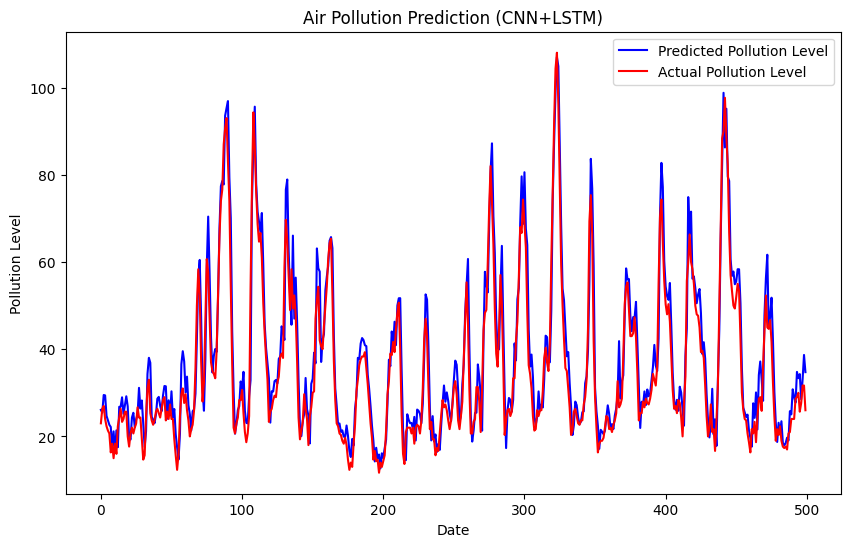

In [56]:

# Vẽ đồ thị so sánh giá trị thực và dự đoán
plt.figure(figsize=(10, 6))
plt.plot(inv_yhat[:500], color='blue', label='Predicted Pollution Level')
plt.plot(inv_y[:500], color='red', label='Actual Pollution Level')
plt.title("Air Pollution Prediction (CNN+LSTM)")
plt.xlabel("Date")
plt.ylabel("Pollution Level")
plt.legend()
plt.show()